<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| [Emmanuel Rachelson](https://personnel.isae-supaero.fr/emmanuel-rachelson?lang=en) | <a href="https://erachelson.github.io/RLclass_MVA/">https://erachelson.github.io/RLclass_MVA/</a>

<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Chapter 4: From fitted Q-iteration to deep Q-networks</div>

<div class="alert alert-success">

**Learning outcomes**   
By the end of this chapter, you should be able to:
- write and execute a fitted Q-iteration algorithm with any offline regression method,
- explain the limitations of fitted Q-iteration,
- implement the deep Q-networks architecture(s) and algorithm, and their immediate improvements with target networks, gradient clipping and alternate optimizers,
- discuss the limitations of DQN, list improvements present in Rainbow, and cite their sources.

Additionally, after doing the homework(*), you should be able to:
- explain and implement n-step returns
- explain and implement double DQN
- explain and implement prioritized experience replay
- explain and implement C51
- explain and implement NoisyNets
- explain and implement Munchausen DQN

(*) as of Nov 13th, 2024, this part is not implemented yet.
</div>

In this second series of chapters, we confront our foundational knowledge to various challenges in RL: continuous, sometimes high-dimensional state spaces, sparse rewards, difficult exploration with deceptive rewards, continuous actions, etc. Most problems will combine several of these challenges. We will take an algorithmic approach, building modern RL algorithms as solutions to these challenges.

In this chapter, we build upon the foundations of approximate value iteration (AVI), which we studied in depth previously and which enabled designing Q-learning. We depart from toy problems and dive into larger scale ones, with the intention to build approximate value iteration algorithms that scale to challenging environments.

# Environments

## Cart-pole

Full description on the [gymnasium website](https://gymnasium.farama.org/environments/classic_control/cart_pole/).

> A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

In [3]:
!pip install pygame

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 51.8 MB/s eta 0:00:00a 0:00:01


Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space: Discrete(2)
Starting state: [-0.01739825 -0.01098221  0.04984295 -0.03530816]


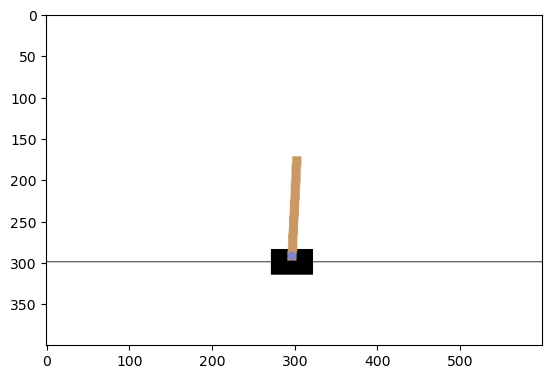

In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt
cartpole = gym.make('CartPole-v1', render_mode="rgb_array")
print("Observation space:", cartpole.observation_space)
print("Action space:", cartpole.action_space)
s,_ = cartpole.reset()
print("Starting state:", s)
plt.imshow(cartpole.render());

In [3]:
import gymnasium as gym
cartpole = gym.make('CartPole-v1', render_mode="human")
s,_ = cartpole.reset()
for t in range(200):
    s2,r,d,trunc,_ = cartpole.step(cartpole.action_space.sample())
    cartpole.render()
    if d:
        break

In [4]:
cartpole.close()

## Acrobot

Full description on the [gymnasium website](https://gymnasium.farama.org/environments/classic_control/acrobot/).

> The system consists of two links connected linearly to form a chain, with one end of the chain fixed. The joint between the two links is actuated. The goal is to apply torques on the actuated joint to swing the free end of the linear chain above a given height while starting from the initial state of hanging downwards.

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
acrobot = gym.make('Acrobot-v1', render_mode="rgb_array")
print("Observation space:", acrobot.observation_space)
print("Action space:", acrobot.action_space)
s,_ = acrobot.reset()
print("Starting state:", s)
plt.imshow(acrobot.render());

In [ ]:
import gymnasium as gym
acrobot = gym.make('Acrobot-v1', render_mode="human")
s,_ = acrobot.reset()
for t in range(200):
    s2,r,d,trunc,_ = acrobot.step(acrobot.action_space.sample())
    acrobot.render()
    if d:
        break

In [ ]:
acrobot.close()

## Pong

Let's build an agent that learns to play Pong, one of the [Atari games](https://gymnasium.farama.org/environments/atari/pong/) in Gymnasium (originally in the [Arcade Learning Environment](https://github.com/mgbellemare/Arcade-Learning-Environment)). You might want to try different games later on (like the popular Breakout game for instance).

Here is the environment's description.
> Maximize your score in the Atari 2600 game Pong. In this environment, the observation is an RGB image of the screen, which is an array of shape (210, 160, 3). Each action is repeatedly performed for a duration of k frames, where k is uniformly sampled from $\{2, 3, 4\}$.

In [6]:
import gymnasium as gym
import matplotlib.pyplot as plt
pong = gym.make("PongNoFrameskip-v4", render_mode="rgb_array")
print("Observation space:", pong.observation_space)
print("Action space:", pong.action_space)
s,_ = pong.reset()
plt.imshow(pong.render(),vmin=0,vmax=255);

NamespaceNotFound: Namespace ALE not found. Have you installed the proper package for ALE?

<div class="alert alert-warning">

**Exercise:** What is the number of possible states? Why is this not an MDP? What would one need to turn this back into an MDP?
</div>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>

One frame is a $210\times 160$ RGB image with a 256 color palette, so the set of all possible frames has size $256^{210 \times 160 \times 3} \sim 10^{242579}$. That's a little too many for an efficient enumeration. Of course, most of the possible images will never occur in a Breakout game and the true state space is actually a much smaller subset of the full set of possible images. Nevertheless, unless we provide a large engineering effort in describing the state space with few variables (which would be contradictory of our goal of a "human-level" AI) we will need to automatically discover some structure in the state sampled data.

This is not an MDP because the transition dynamics do not respect Markov's property. The probability of transitioning from $s_t$ to $s_{t+1}$ is *not* independent of previous states. The problem here is that a single frame of the game does not reflect the velocity of the ball.

To recover Markov's property one could simply stack a few frames together in the state space.
</details>

There are 18 buttons on the Atari controller. However not all games use all buttons. Our interface to Pong specifies 6 possible actions:

In [ ]:
print(pong.unwrapped.get_action_meanings())

Gymnasium provides us with a number of environment wrappers that help preprocessing observations, actions or environment-specific features. There is [one such wrapper for Atari games](https://gymnasium.farama.org/api/wrappers/misc_wrappers/#gymnasium.wrappers.AtariPreprocessing).

In [ ]:
from gymnasium.wrappers import AtariPreprocessing
pong = AtariPreprocessing(pong)

In [ ]:
print(pong.observation_space)
print(pong.action_space)

In [ ]:
# Trying a random agent in Pong
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

_,_ = pong.reset()
for i in range(60):
    a = np.random.randint(2)
    x, r, _, _, _ = pong.step(a)
    
print("shape: ", x.shape, ", min = ", x.min(), ", max = ", x.max(), ", dtype = ", x.dtype, sep='')
plt.imshow(x, cmap='gray');

# Fitted Q-iteration

## Reminder: AVI as a series of risk minimization problems

<div class="alert alert-success">

**Approximate value iteration as a sequence of risk minimization problems**  
$$\pi_n \in \mathcal{G} q_n,$$
$$L_n(\theta) = \frac{1}{2} \mathbb{E}_{(s,a) \sim \rho}\left[ \left( q(s,a;\theta) - G^{\pi_n}_1(s,a,q_n) \right)^2 \right],$$
$$\theta_{n+1} \in \arg\min_{\theta} L_n(\theta),$$
$$q_{n+1}(s,a) = q(s,a;\theta_{n+1}).$$
</div>

With 
$$\pi \in \mathcal{G} q \quad \Leftrightarrow \quad \pi(s) \in \arg\max_{\pi \in \Delta_A} \mathbb{E}_{a\sim\pi} \left[q(s,a)\right]$$

And
$$G^\pi_1(s,a,q) = R_0 + \gamma q(S_1, A_1) \quad \Bigg| \quad \begin{array}{l}S_0 = s, A_0=a\\ A_1 \sim \pi(S_1),\\ S_{1}\sim p(\cdot|S_0,A_0),\\ R_0 = r(S_0,A_0,S_{1}).\end{array}$$

In the previous chapter, we saw that the exact, tabular representation of $q$ was actually a linear model. In turn, this opened the possibility to use stochastic approximation to solve the $\min_\theta L_n(\theta)$ problem, leading to Q-learning and SARSA.

Such representations do not scale to large state spaces, and we know we should turn to function approximation sooner or later. 
Given iid samples $(s,a,r,s')$, solving $\min_\theta L_n(\theta)$ translates to a supervised learning problem whose inputs $x$ are $x=(s,a)$ pairs, and outputs $y$ are $y=r+\gamma \mathbb{E}_{a'\sim \pi_n(s')} q_n(s',a')$.  

While, in the previous chapter, stochastic approximation enabled learning $\min_\theta L_n(\theta)$ with on-the-fly acquired samples (provided the function approximator was differentiable), it seems reasonable to enable storage of samples, leading to a training set of iid samples $\{(s,a,r,s')\}$ which we called an *experience replay memory* or *replay buffer*: with this, the regression problem now has a function representation space and a training set of input-output pairs $\{(x,y)\}$.

The supervised learning literature provides us with a span of efficient methods to solve such a regression problem. 
Random forests is a reasonably all-purpose method, with great properties in many cases: let's build a sample-based AVI method using random forests.

In general, the use of supervised learning regressors as approximators of the sequence of AVI's Q-functions is called **fitted Q-iteration (FQI)**.

## A random forest based FQI algorithm.

One often considers that the two historical papers implementing FQI algorithms are the ones describing **[Tree-Based Batch Mode Reinforcement Learning](https://www.jmlr.org/papers/volume6/ernst05a/ernst05a.pdf)** (Ernst et al., 2005) and **[Neural Fitted Q Iteration](https://link.springer.com/chapter/10.1007/11564096_32)** (Riedmiller, 2005). Of course they were not the only ones but they are often quoted as milestones in RL history.

We are going to implement an algorithm which is very close to that presented in the Tree-Based Batch Mode Reinforcement Learning paper. The main difference is that the authors employed a variant of random forests called extra trees. Scikit-learn provides an implementation of both random forests and extra trees, feel free to swap one for the other in what follows. 

The first step to perform FQI is to collect and store a dataset of samples. 
<div class="alert alert-warning">

**Exercise:**  
Collect $10^4$ samples using a uniformly random policy and store them.
</div>

In [ ]:
import numpy as np
from tqdm import tqdm

def collect_samples(env, horizon, disable_tqdm=False, print_done_states=False):
    s, _ = env.reset()
    #dataset = []
    S = []
    A = []
    R = []
    S2 = []
    D = []
    for _ in tqdm(range(horizon), disable=disable_tqdm):
        a = env.action_space.sample()
        s2, r, done, trunc, _ = env.step(a)
        #dataset.append((s,a,r,s2,done,trunc))
        S.append(s)
        A.append(a)
        R.append(r)
        S2.append(s2)
        D.append(done)
        if done or trunc:
            s, _ = env.reset()
            if done and print_done_states:
                print("done!")
        else:
            s = s2
    S = np.array(S)
    A = np.array(A).reshape((-1,1))
    R = np.array(R)
    S2= np.array(S2)
    D = np.array(D)
    return S, A, R, S2, D

In [ ]:
import gymnasium as gym
cartpole = gym.make('CartPole-v1', render_mode="rgb_array")
S,A,R,S2,D = collect_samples(cartpole, int(1e4))
print("nb of collected samples:", S.shape[0])
for i in range(3):
    print("sample", i, "\n  state:", S[i], "\n  action:", A[i], "\n  reward:", R[i], "\n  next state:", S2[i], "\n terminal?", D[i])

Now let's consider $q_0$ is the constant zero function and train a random forest to learn $q_1$.

<div class="alert alert-warning">

**Exercise:**  
Construct the training set to learn $q_1$, then train it.
</div>

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

SA = np.append(S,A,axis=1)
value = R.copy()

Q1 = RandomForestRegressor()
Q1.fit(SA,value);

In [ ]:
# compute MSE
print("training MSE:", np.mean((value-Q1.predict(SA))**2))

<div class="alert alert-warning">

**Exercise:**  
Restart from scratch and write the loop that builds the sequence of AVI Q-functions. Store all successive Q-functions.
</div>

In [ ]:
# %load solutions/rf_fqi.py
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

def rf_fqi(S, A, R, S2, D, iterations, nb_actions, gamma, disable_tqdm=False):
    nb_samples = S.shape[0]
    Qfunctions = []
    SA = np.append(S,A,axis=1)
    for iter in tqdm(range(iterations), disable=disable_tqdm):
        if iter==0:
            value=R.copy()
        else:
            Q2 = np.zeros((nb_samples,nb_actions))
            for a2 in range(nb_actions):
                A2 = a2*np.ones((S.shape[0],1))
                S2A2 = np.append(S2,A2,axis=1)
                Q2[:,a2] = Qfunctions[-1].predict(S2A2)
            max_Q2 = np.max(Q2,axis=1)
            value = R + gamma*(1-D)*max_Q2
        Q = RandomForestRegressor()
        Q.fit(SA,value)
        Qfunctions.append(Q)
    return Qfunctions


In [ ]:
gamma = .9
nb_iter = 10
nb_actions = cartpole.action_space.n
Qfunctions = rf_fqi(S, A, R, S2, D, nb_iter, nb_actions, gamma)

In [ ]:
import matplotlib.pyplot as plt

# Value of an initial state across iterations
s0,_ = cartpole.reset()
Vs0 = np.zeros(nb_iter)
for i in range(nb_iter):
    Qs0a = []
    for a in range(cartpole.action_space.n):
        s0a = np.append(s0,a).reshape(1, -1)
        Qs0a.append(Qfunctions[i].predict(s0a))
    Vs0[i] = np.max(Qs0a)
plt.plot(Vs0)

# Bellman residual
residual = []
for i in range(1,nb_iter):
    residual.append(np.mean((Qfunctions[i].predict(SA)-Qfunctions[i-1].predict(SA))**2))
plt.figure()
plt.plot(residual);

<div class="alert alert-warning">

**Exercise:**  
Evaluate graphically and qualitatively how the last learned policy performs.
</div>

In [ ]:
def greedy_action(Q,s,nb_actions):
    Qsa = []
    for a in range(nb_actions):
        sa = np.append(s,a).reshape(1, -1)
        Qsa.append(Q.predict(sa))
    return np.argmax(Qsa)

In [ ]:
import gymnasium as gym
cartpole = gym.make('CartPole-v1', render_mode="human")
s,_ = cartpole.reset()
for t in range(500):
    a = greedy_action(Qfunctions[-1],s,cartpole.action_space.n)
    s2,r,d,trunc,_ = cartpole.step(a)
    cartpole.render()
    s = s2
    if d:
        break

In [ ]:
cartpole.close()

## Discussion

Eventually, we have a fully offline procedure that seems to achieve an efficient control for the cart-pole (or acrobot) environment. This is a rather strong result: with fully offline samples we seem to be able to learn good controlers.

But there are limits to this approach, mostly due to the mismatch between $\rho$ and the states and actions actually visited by the learned policy $\pi$.  
What would have happened if, in acrobot, there had been no sample with `done=True` in the training set?  
Isn't the totally random collection of samples a waste of computational resources in some states, and a lack of exploration in others?

Some samples in the training set might be very redundant or completely unrelated to states encountered by $\pi$. Their presence in the training set biases the loss. Additionally, collecting them did cost us some computing time, which might have been better used.  
Conversely, some states and actions visited by $\pi$ might be absent from the support of $\rho$. Because of this, there are no good estimates of $q(s,a)$ obtained from the training set, which prevent actually incrementally improving $\pi$.  
We discussed this in the previous chapter when we covered the importance of the behavior distribution.

A simple empirical fix to this problem would be to enrich the training set incrementally, by performing rounds of data collection at every iteration of FQI, collecting samples from $(s,a)$ pairs seen by $\pi_n$ and also exploring new actions is the corresponding states $s$.

We won't implement this now and turn to a more online procedure. However, note that offline RL received a lot of attention and analysis in recent years and is still a very active field of research.

# Neural networks for AVI: deep Q-networks

## Back to AVI as a series of risk minimization problems

Again, let us return to the original formulation of AVI as a sequence of supervised learning problems.

<div class="alert alert-success">

**Approximate value iteration as a sequence of risk minimization problems**  
$$\pi_n \in \mathcal{G} q_n,$$
$$L_n(\theta) = \frac{1}{2} \mathbb{E}_{(s,a) \sim \rho}\left[ \left( q(s,a;\theta) - G^{\pi_n}_1(s,a,q_n) \right)^2 \right],$$
$$\theta_{n+1} \in \arg\min_{\theta} L_n(\theta),$$
$$q_{n+1}(s,a) = q(s,a;\theta_{n+1}).$$
</div>

With 
$$\pi \in \mathcal{G} q, \Leftrightarrow \pi(s) \in \arg\max_{\pi \in \Delta_A} \mathbb{E}_{a\sim\pi} \left[q(s,a)\right]$$

And
$$G^\pi_1(s,a,Q) = R_0 + \gamma q(S_1, A_1) \quad \Bigg| \quad \begin{array}{l}S_0 = s, A_0=a\\ A_1 \sim \pi(S_1),\\ S_{1}\sim p(\cdot|S_0,A_0),\\ R_0 = r(S_0,A_0,S_{1}).\end{array}$$

If this risk is differentiable, ie. if $q$ is differentiable with respect to $\theta$, provided one can draw a mini-batch of independently and identically drawn samples $\left\{\left(s_i,a_i,r_i,s'_i\right)\right\}_{i\in [1,B]}$ (either by sampling from a larger training set, or directly from the system to control), with $(s,a) \sim \rho(\cdot)$ and $s',a' \sim p(s' | s,a)\pi(a'|s')$, then one can derive a stochastic gradient descent learning procedure and iteratively learn $\theta_{n+1}$ as the limit of the sequence $\theta_{k+1} \leftarrow \theta_{k} + \alpha_k d_n(\theta_{k})$ with 
$$d_n(\theta) = \frac{1}{B} \sum_{i=1}^B \left[ \left( r_i + \gamma q(s_i',\pi_n(s'_i);\theta_{n}) - q(s_i,a_i;\theta) \right) \nabla_\theta q(s_i,a_i;\theta) \right].$$

This type of SGD optimization is precisely what is done in neural networks optimization.

<div class="alert alert-warning">

**Exercise:**  
Do you recall what are the differences with Q-learning?
</div>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>

In Q-learning, there was no training set and the samples were collected on-the-fly.  
So $B=1$. 
But also, two consecutive samples were higly correlated, breaking the iid assumption.
</details>

## Experience Replay

To recover the independence assumption between samples, we can, as previously, introduce the mechanism of [*Experience Replay*](https://link.springer.com/article/10.1007/BF00992699) by storing past samples into a *Replay Memory*. When samples a required for a mini-batch gradient update, the samples are collected uniformly from the replay memory, thus mimicking an (almost) independent draw according to $\rho(\cdot)$.

<div class="alert alert-warning">
    
**Exercise:**  
Design a class for storing and sampling experience samples. Limit the size of this memory (via a FIFO mechanism) to a fixed number of samples (adapt this number to your computer's RAM). Test it by running a random policy for $2\cdot 10^6$ time steps.
</div>

In [ ]:
# %load solutions/replay_buffer.py
import random

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity # capacity of the buffer
        self.data = []
        self.index = 0 # index of the next cell to be filled
    def append(self, s, a, r, s_, d):
        if len(self.data) < self.capacity:
            self.data.append(None)
        self.data[self.index] = (s, a, r, s_, d)
        self.index = (self.index + 1) % self.capacity
    def sample(self, batch_size):
        return random.sample(self.data, batch_size)
    def __len__(self):
        return len(self.data)

In [ ]:
# Testing insertion in the ReplayBuffer class
from tqdm import trange
import gymnasium as gym
cartpole = gym.make('CartPole-v1', render_mode="rgb_array")
replay_buffer_size = int(1e6)
nb_samples = int(2e6)

memory = ReplayBuffer(replay_buffer_size)
state, _ = cartpole.reset()
print("Testing insertion of", nb_samples, "samples in the replay buffer")
for _ in trange(nb_samples):
    action = cartpole.action_space.sample()
    next_state, reward, done, trunc, _ = cartpole.step(action)
    memory.append(state, action, reward, next_state, done)
    if done:
        state, _ = cartpole.reset()
    else:
        state = next_state

print("Replay buffer size:", len(memory))

# Testing sampling in the ReplayBuffer class
nb_batches = int(1e4)
batch_size = 50
import random

print("Testing sampling of", nb_batches, "minibatches of size", batch_size, "from the replay buffer")
for _ in trange(nb_batches):
    batch = memory.sample(batch_size)

print("Example of a 2-sample minibatch", memory.sample(2))

<div class="alert alert-warning">
    
**Know your data structures!**

Taking some time to think about what makes a good replay buffer may save you hours of puzzled head-banging. It is important to know what you expect from your replay buffer to choose the right data structure.

Common mistake: we need a fixed sized memory, that works like a FIFO structure, so let's pick a [deque](https://docs.python.org/3/library/collections.html#collections.deque) (double-ended queue). That sounds fair, deques (in Python) have a fixed maximum size and constant time insertion at the beginning and the end. BUT they also have [$O(n)$ access time](https://wiki.python.org/moin/TimeComplexity) which means that for large replay buffers, sampling a minibatch may take forever.

Here, what we really need is a fixed-size FIFO, with $O(1)$ insertion at the end and $O(1)$ access.

This should motivate the choices made in the replay buffer class above.

If you want empirical verification of the reasoning above, in the "replay memory" folder, you will find a short notebook enabling empirical testing of many different data structures for replay buffers.
</div>

## A deep Q-network

The term Deep Q-Network was coined by the (now historical) paper **[Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602)** by Mnih et al. (2013) that put forward the main ideas we develop here. All those were later popularized by DeepMind's paper in Nature **[Human-level control through deep reinforcement learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning)** by Mnih et al. (2015).

Let's design a (deep) neural network that will serve as a function approximator for $q(s,a;\theta)$. 

<center><img src="img/dqlas.png" height="15%" width="15%"></img></center>

Note that since we're going to have to compute $\max_a q(s,a)$ and since actions are discrete, it is preferable to avoid running as many passes through the network as there are actions. Therefore, instead of the network structure above, we will prefer to use the one below.

<center><img src="img/dqls.png" height="30%" width="30%"></img></center>

<div class="alert alert-warning">
    
**Exercise:**  
Declare a simple neural network for our $q$ function with 2 hidden layers and 24 neurons on each layer.
</div>

In [ ]:
import torch
import torch.nn as nn
import gymnasium as gym
cartpole = gym.make('CartPole-v1', render_mode="rgb_array")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state_dim = cartpole.observation_space.shape[0]
n_action = cartpole.action_space.n 
nb_neurons=24

DQN = torch.nn.Sequential(nn.Linear(state_dim, nb_neurons),
                          nn.ReLU(),
                          nn.Linear(nb_neurons, nb_neurons),
                          nn.ReLU(), 
                          nn.Linear(nb_neurons, n_action)).to(device)

We're almost there. Now we can implement the algorithm that:
- takes $\epsilon$-greedy actions with respect to $q$
- stores samples in the replay buffer
- at each interaction step with the environment, draws a mini-batch, computes the target values for each $(s,a)$ and takes a gradient step.
- repeats

<div class="alert alert-warning">
    
**Exercise:**  
Write this algorithm's pseudo-code.  
You can take inspiration from the algorithm on page 5 of **[Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602)**.
</div>



<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>

         state = init()
         loop:
            action = greedy_action(DQN) or random_action()
            new_state, reward = step(state, action)
            replay_memory.add(state, action, reward, new_state)
            minibatch = replay_memory.sample(minibatch_size)
            X_train = Y_train = []
            for (s,a,r,s') in minibatch:
                Q  = DQN.predict(s)
                Q' = DQN.predict(s')
                if non-terminal(s'): 
                    update = r + gamma * max(Q')    
                else:  
                    update = r
                Q[a] = update
                X_train.append(s)
                Y_train.append(Q)
            DQN.train_one_step(X_train,Y_train)
            state = new_state
</details>

Now we can proceed with the implementation. This series of exercises break it down into small steps.

<div class="alert alert-warning">
    
**Exercise:**  
It will actually be useful to have separate torch.Tensor for the each element type in the sampled minibatch.  
That is one Tensor for a minibatch of states, another for actions, etc.
Let's redefine the sample function of our replay buffer class to that end.
</div>

In [ ]:
# %load solutions/replay_buffer2.py
import random
import torch
import numpy as np

class ReplayBuffer:
    def __init__(self, capacity, device):
        self.capacity = int(capacity) # capacity of the buffer
        self.data = []
        self.index = 0 # index of the next cell to be filled
        self.device = device
    def append(self, s, a, r, s_, d):
        if len(self.data) < self.capacity:
            self.data.append(None)
        self.data[self.index] = (s, a, r, s_, d)
        self.index = (self.index + 1) % self.capacity
    def sample(self, batch_size):
        batch = random.sample(self.data, batch_size)
        return list(map(lambda x:torch.Tensor(np.array(x)).to(self.device), list(zip(*batch))))
    def __len__(self):
        return len(self.data)

<div class="alert alert-warning">
    
**Exercise:**  
Define a utility function that computes the greedy action from a DQN and a batch of states.
</div>

In [ ]:
# %load solutions/dqn_greedy_action.py
import torch

def greedy_action(network, state):
    device = "cuda" if next(network.parameters()).is_cuda else "cpu"
    with torch.no_grad():
        Q = network(torch.Tensor(state).unsqueeze(0).to(device))
        return torch.argmax(Q).item()

<div class="alert alert-warning">
    
**Exercise:**  
Write a class that keeps a replay buffer as internal attribute and implements the pseudo-code you wrote earlier.  
Here are a few tips:
- To ensure exploration, take a constant $\epsilon_{max}$ value during $\tau_{delay}$ time steps, then substract $\epsilon_{step}$ from $\epsilon$ at every time step until you reach time $\tau_{period}$.
- A common optimizer (instead of plain SGD) is ADAM (or RMSprop).
- Assume the interaction with the environment will be episodic. After each training episode store the episode's cumulated return for monitoring.

Write your class but don't run this code just yet!
</div>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from solutions.replay_buffer2 import ReplayBuffer
from solutions.dqn_greedy_action import greedy_action

class dqn_agent:
    def __init__(self, config, model):
        device = "cuda" if next(model.parameters()).is_cuda else "cpu"
        self.gamma = config['gamma']
        self.batch_size = config['batch_size']
        self.nb_actions = config['nb_actions']
        self.memory = ReplayBuffer(config['buffer_size'], device)
        self.epsilon_max = config['epsilon_max']
        self.epsilon_min = config['epsilon_min']
        self.epsilon_stop = config['epsilon_decay_period']
        self.epsilon_delay = config['epsilon_delay_decay']
        self.epsilon_step = (self.epsilon_max-self.epsilon_min)/self.epsilon_stop
        self.model = model 
        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config['learning_rate'])
    
    def gradient_step(self):
        if len(self.memory) > self.batch_size:
            X, A, R, Y, D = self.memory.sample(self.batch_size)
            QYmax = self.model(Y).max(1)[0].detach()
            #update = torch.addcmul(R, self.gamma, 1-D, QYmax)
            update = torch.addcmul(R, 1-D, QYmax, value=self.gamma)
            QXA = self.model(X).gather(1, A.to(torch.long).unsqueeze(1))
            loss = self.criterion(QXA, update.unsqueeze(1))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step() 
    
    def train(self, env, max_episode):
        episode_return = []
        episode = 0
        episode_cum_reward = 0
        state, _ = env.reset()
        epsilon = self.epsilon_max
        step = 0

        while episode < max_episode:
            # update epsilon
            if step > self.epsilon_delay:
                epsilon = max(self.epsilon_min, epsilon-self.epsilon_step)

            # select epsilon-greedy action
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = greedy_action(self.model, state)

            # step
            next_state, reward, done, trunc, _ = env.step(action)
            self.memory.append(state, action, reward, next_state, done)
            episode_cum_reward += reward

            # train
            self.gradient_step()

            # next transition
            step += 1
            if done:
                episode += 1
                print("Episode ", '{:3d}'.format(episode), 
                      ", epsilon ", '{:6.2f}'.format(epsilon), 
                      ", batch size ", '{:5d}'.format(len(self.memory)), 
                      ", episode return ", '{:4.1f}'.format(episode_cum_reward),
                      sep='')
                state, _ = env.reset()
                episode_return.append(episode_cum_reward)
                episode_cum_reward = 0
            else:
                state = next_state

        return episode_return

<div class="alert alert-warning">
    
**Exercise:**  
Train for 200 episodes on CartPole, with a learning rate of $0.001$, abatch size of $20$, $\gamma=0.95$ and a replay buffer of maximum $1000000$ samples. Take $\epsilon_{max}=1$, $\epsilon_{min}=0.01$, $\tau_{delay}=20$ and $\tau_{period}=1000$.
</div>

In [ ]:
import gymnasium as gym
cartpole = gym.make('CartPole-v1', render_mode="rgb_array")
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Declare network
state_dim = cartpole.observation_space.shape[0]
n_action = cartpole.action_space.n 
nb_neurons=24
DQN = torch.nn.Sequential(nn.Linear(state_dim, nb_neurons),
                          nn.ReLU(),
                          nn.Linear(nb_neurons, nb_neurons),
                          nn.ReLU(), 
                          nn.Linear(nb_neurons, n_action)).to(device)

# DQN config
config = {'nb_actions': cartpole.action_space.n,
          'learning_rate': 0.001,
          'gamma': 0.95,
          'buffer_size': 1000000,
          'epsilon_min': 0.01,
          'epsilon_max': 1.,
          'epsilon_decay_period': 1000,
          'epsilon_delay_decay': 20,
          'batch_size': 20}

# Train agent
agent = dqn_agent(config, DQN)
scores = agent.train(cartpole, 200)
plt.plot(scores)

<div class="alert alert-warning">

**Exercise:**  
Observe how the learned policy behaves.
</div>

In [ ]:
import gymnasium as gym
from solutions.dqn_greedy_action import greedy_action

cartpole = gym.make('CartPole-v1', render_mode="human")
s,_ = cartpole.reset()
for t in range(1000):
    a = greedy_action(DQN,s)
    s2,r,d,trunc,_ = cartpole.step(a)
    cartpole.render()
    s = s2
    if d:
        break

cartpole.close()

## Target networks

Let's take a step back. In the end, we have done something quite similar to Q-learning: at every iteration of AVI, the $q_{n+1} = \mathbb{A}\mathbb{T}^* q_n$ we compute is obtained by taking a single gradient step in the direction of $\mathbb{T}^* q_n$. This enabled having a single network in memory, and using it to bootstrap its own training samples.

A single gradient step makes for a poor function approximator. In turn, the sequence of $q_n$ functions might be quite unstable and noisy, in particular with environments that have large variance in $s'$ and $r$ (which is not the case for the cart-pole environment). This can be greatly improved by taking several gradient steps on a given loss function $L_n$, instead of taking a single step and changing the loss function after each sample. This idea is the same as that of delayed updates that we introduced in the chapter on temporal difference learning. 

So, instead of having a single network, we wish to keep $q_n$ in memory so that we can refine our approximation $q_{n+1}$.

In practice, this is achieved by the introduction of a *target network* whose parameters are noted $\theta^-$, and who plays the role of $q_n$ when learning $q_{n+1}$. 
Surprisingly and despite its straightforward roots in AVI, this idea was not implemented in the 2013 **[Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602)** paper which introduced DQN. One had to wait for the 2015 **[Human-level control through deep reinforcement learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning)** paper to see the introduction of target networks. So the loss of DQN with a target network is:
$$L(\theta) = \mathbb{E}_{s,a,r,s'} \left[ \left( r + \gamma \max_{a'} q(s',a',\theta^-) - q(s,a;\theta) \right) ^2 \right],$$
and the target network parameters $\theta^-$ are only updated with the Q-network parameters $\theta_n$ every $C$ steps and are held fixed between individual updates.

Note that more recent approaches smooth out this accumulation process by defining an exponential moving average update at every time step, of the form:
$$\theta^- \leftarrow \tau \theta + (1-\tau) \theta^-.$$

<div class="alert alert-warning">

**Exercise:**  
Is this the same thing as taking several gradient steps after each sample?
</div>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>

Beware, here be dragons!   

No, this is not the same thing. At all.
By synchronizing gradient steps, we make sure the replay buffer always tracks the behavior distribution of the current policy. That is: the replay buffer features samples that correspond to trying greedy or exploratory actions in states which are likely to be encountered, and hence, it contains crucial information for policy improvement.

Here, by using target networks, we don't break this synchronization. We retain it as we update $\theta$. We simply allow $q_\theta$ to better fit $\mathbb{T}^* q_n$ before we move on to the next iteration of AVI.

Conversely, taking several gradient steps on $L_n$ without collecting new data implies taking the risk that the behavior policy's state distribution drifts away from the replay buffer's empirical distribution. In turn, this leads to the risk that gradient updates after the first one are ill-informed. In very easy environments (eg. when state space coverage is rather easy to achieve, like in cart-pole), this can be benign and go unnoticed. But beware: in many difficult situations (eg. when the environment is difficult to explore, when stochasticity is high, when state distributions change quickly with parameter updates, etc.) this can quickly lead to policies that make no sense and eventually perform really badly.

An interesting analysis of this dependency can be found in the **[The Difficulty of Passive Learning in Deep Reinforcement Learning](https://openreview.net/forum?id=nPHA8fGicZk)** paper by Ostrovski et al. (2021).
</details>

## Losses and optimizers

It might seem trivial, but the question of which optimizer to choose is quite open in RL. Most common choices are RMSprop or Adam (with, sometimes, carefully chosen hyperparameters). For the example of CartPole, it seems Adam with default parameters works better, but that's not a general rule.

Another common pratice to stabilize learning is to clip the value of the loss' gradient between $-1$ and $1$. This is not such an uncommon trick, it actually amounts to using an L2 loss for values of the loss between $-1$ and $1$ and an L1 loss outside of this domain. This is also know as the [Huber Loss](https://en.wikipedia.org/wiki/Huber_loss) or the [smooth L1 loss](https://pytorch.org/docs/stable/nn.html#smoothl1loss).

<div class="alert alert-warning">

**Exercise:**  
Modify the previous `dqn_agent` class to include a target network, with an option to perform periodic updates or moving average updates, the possibility to take several gradient steps after each sample, and options for choosing the loss and the optimizer.
</div>

In [ ]:
# %load solutions/dqn_agent.py
import numpy as np
import torch
import torch.nn as nn
from copy import deepcopy
from solutions.replay_buffer2 import ReplayBuffer
from solutions.dqn_greedy_action import greedy_action

class dqn_agent:
    def __init__(self, config, model):
        device = "cuda" if next(model.parameters()).is_cuda else "cpu"
        self.nb_actions = config['nb_actions']
        self.gamma = config['gamma'] if 'gamma' in config.keys() else 0.95
        self.batch_size = config['batch_size'] if 'batch_size' in config.keys() else 100
        buffer_size = config['buffer_size'] if 'buffer_size' in config.keys() else int(1e5)
        self.memory = ReplayBuffer(buffer_size,device)
        self.epsilon_max = config['epsilon_max'] if 'epsilon_max' in config.keys() else 1.
        self.epsilon_min = config['epsilon_min'] if 'epsilon_min' in config.keys() else 0.01
        self.epsilon_stop = config['epsilon_decay_period'] if 'epsilon_decay_period' in config.keys() else 1000
        self.epsilon_delay = config['epsilon_delay_decay'] if 'epsilon_delay_decay' in config.keys() else 20
        self.epsilon_step = (self.epsilon_max-self.epsilon_min)/self.epsilon_stop
        self.model = model 
        self.target_model = deepcopy(self.model).to(device)
        self.criterion = config['criterion'] if 'criterion' in config.keys() else torch.nn.MSELoss()
        lr = config['learning_rate'] if 'learning_rate' in config.keys() else 0.001
        self.optimizer = config['optimizer'] if 'optimizer' in config.keys() else torch.optim.Adam(self.model.parameters(), lr=lr)
        self.nb_gradient_steps = config['gradient_steps'] if 'gradient_steps' in config.keys() else 1
        self.update_target_strategy = config['update_target_strategy'] if 'update_target_strategy' in config.keys() else 'replace'
        self.update_target_freq = config['update_target_freq'] if 'update_target_freq' in config.keys() else 20
        self.update_target_tau = config['update_target_tau'] if 'update_target_tau' in config.keys() else 0.005
    
    def gradient_step(self):
        if len(self.memory) > self.batch_size:
            X, A, R, Y, D = self.memory.sample(self.batch_size)
            QYmax = self.target_model(Y).max(1)[0].detach()
            update = torch.addcmul(R, 1-D, QYmax, value=self.gamma)
            QXA = self.model(X).gather(1, A.to(torch.long).unsqueeze(1))
            loss = self.criterion(QXA, update.unsqueeze(1))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step() 
    
    def train(self, env, max_episode):
        episode_return = []
        episode = 0
        episode_cum_reward = 0
        state, _ = env.reset()
        epsilon = self.epsilon_max
        step = 0
        while episode < max_episode:
            # update epsilon
            if step > self.epsilon_delay:
                epsilon = max(self.epsilon_min, epsilon-self.epsilon_step)
            # select epsilon-greedy action
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = greedy_action(self.model, state)
            # step
            next_state, reward, done, trunc, _ = env.step(action)
            self.memory.append(state, action, reward, next_state, done)
            episode_cum_reward += reward
            # train
            for _ in range(self.nb_gradient_steps): 
                self.gradient_step()
            # update target network if needed
            if self.update_target_strategy == 'replace':
                if step % self.update_target_freq == 0: 
                    self.target_model.load_state_dict(self.model.state_dict())
            if self.update_target_strategy == 'ema':
                target_state_dict = self.target_model.state_dict()
                model_state_dict = self.model.state_dict()
                tau = self.update_target_tau
                for key in model_state_dict:
                    target_state_dict[key] = tau*model_state_dict[key] + (1-tau)*target_state_dict[key]
                target_model.load_state_dict(target_state_dict)
            # next transition
            step += 1
            if done or trunc:
                episode += 1
                print("Episode ", '{:3d}'.format(episode), 
                      ", epsilon ", '{:6.2f}'.format(epsilon), 
                      ", batch size ", '{:5d}'.format(len(self.memory)), 
                      ", episode return ", '{:4.1f}'.format(episode_cum_reward),
                      sep='')
                state, _ = env.reset()
                episode_return.append(episode_cum_reward)
                episode_cum_reward = 0
            else:
                state = next_state
        return episode_return

In [ ]:
import gymnasium as gym
cartpole = gym.make('CartPole-v1', render_mode="rgb_array")
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Declare network
state_dim = cartpole.observation_space.shape[0]
n_action = cartpole.action_space.n 
nb_neurons=24
DQN = torch.nn.Sequential(nn.Linear(state_dim, nb_neurons),
                          nn.ReLU(),
                          nn.Linear(nb_neurons, nb_neurons),
                          nn.ReLU(), 
                          nn.Linear(nb_neurons, n_action)).to(device)

# DQN config
config = {'nb_actions': cartpole.action_space.n,
          'learning_rate': 0.001,
          'gamma': 0.95,
          'buffer_size': 1000000,
          'epsilon_min': 0.01,
          'epsilon_max': 1.,
          'epsilon_decay_period': 1000,
          'epsilon_delay_decay': 20,
          'batch_size': 20,
          'gradient_steps': 1,
          'update_target_strategy': 'replace', # or 'ema'
          'update_target_freq': 50,
          'update_target_tau': 0.005,
          'criterion': torch.nn.SmoothL1Loss()}

# Train agent
agent = dqn_agent(config, DQN)
scores = agent.train(cartpole, 200)
plt.plot(scores);

In [ ]:
import gymnasium as gym
from solutions.dqn_greedy_action import greedy_action

cartpole = gym.make('CartPole-v1', render_mode="human")
s,_ = cartpole.reset()
for t in range(1000):
    a = greedy_action(DQN,s)
    s2,r,d,trunc,_ = cartpole.step(a)
    cartpole.render()
    s = s2
    if d:
        break

cartpole.close()

## Monitoring progress

In the previous experiments, we have counted the number of steps per training episode. But during these episodes, the applied policy was $\epsilon$-greedy, not greedy. So this is not an objective measure of performance. Let's try to correct this.

<div class="alert alert-warning">
    
**Exercise:**  
Enhance your previous code with the monitoring, after each episode, of:
- the number of steps of the training episode
- a Monte Carlo estimate of the total sum of rewards from the (distribution of) starting state,
- a Monte Carlo estimate of the sum of discounted rewards from the (distribution of) starting state,
- an average, over possible starting states $s_0$ of the current $\max_a Q(s_0,a)$.
</div>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from copy import deepcopy
from solutions.replay_buffer2 import ReplayBuffer
from solutions.dqn_greedy_action import greedy_action

class dqn_agent:
    def __init__(self, config, model):
        device = "cuda" if next(model.parameters()).is_cuda else "cpu"
        self.nb_actions = config['nb_actions']
        self.gamma = config['gamma'] if 'gamma' in config.keys() else 0.95
        self.batch_size = config['batch_size'] if 'batch_size' in config.keys() else 100
        buffer_size = config['buffer_size'] if 'buffer_size' in config.keys() else int(1e5)
        self.memory = ReplayBuffer(buffer_size,device)
        self.epsilon_max = config['epsilon_max'] if 'epsilon_max' in config.keys() else 1.
        self.epsilon_min = config['epsilon_min'] if 'epsilon_min' in config.keys() else 0.01
        self.epsilon_stop = config['epsilon_decay_period'] if 'epsilon_decay_period' in config.keys() else 1000
        self.epsilon_delay = config['epsilon_delay_decay'] if 'epsilon_delay_decay' in config.keys() else 20
        self.epsilon_step = (self.epsilon_max-self.epsilon_min)/self.epsilon_stop
        self.model = model 
        self.target_model = deepcopy(self.model).to(device)
        self.criterion = config['criterion'] if 'criterion' in config.keys() else torch.nn.MSELoss()
        lr = config['learning_rate'] if 'learning_rate' in config.keys() else 0.001
        self.optimizer = config['optimizer'] if 'optimizer' in config.keys() else torch.optim.Adam(self.model.parameters(), lr=lr)
        self.nb_gradient_steps = config['gradient_steps'] if 'gradient_steps' in config.keys() else 1
        self.update_target_strategy = config['update_target_strategy'] if 'update_target_strategy' in config.keys() else 'replace'
        self.update_target_freq = config['update_target_freq'] if 'update_target_freq' in config.keys() else 20
        self.update_target_tau = config['update_target_tau'] if 'update_target_tau' in config.keys() else 0.005
        self.monitoring_nb_trials = config['monitoring_nb_trials'] if 'monitoring_nb_trials' in config.keys() else 0

    def MC_eval(self, env, nb_trials):   # NEW NEW NEW
        MC_total_reward = []
        MC_discounted_reward = []
        for _ in range(nb_trials):
            x,_ = env.reset()
            done = False
            trunc = False
            total_reward = 0
            discounted_reward = 0
            step = 0
            while not (done or trunc):
                a = greedy_action(self.model, x)
                y,r,done,trunc,_ = env.step(a)
                x = y
                total_reward += r
                discounted_reward += self.gamma**step * r
                step += 1
            MC_total_reward.append(total_reward)
            MC_discounted_reward.append(discounted_reward)
        return np.mean(MC_discounted_reward), np.mean(MC_total_reward)
    
    def V_initial_state(self, env, nb_trials):   # NEW NEW NEW
        with torch.no_grad():
            for _ in range(nb_trials):
                val = []
                x,_ = env.reset()
                val.append(self.model(torch.Tensor(x).unsqueeze(0).to(device)).max().item())
        return np.mean(val)
    
    def gradient_step(self):
        if len(self.memory) > self.batch_size:
            X, A, R, Y, D = self.memory.sample(self.batch_size)
            QYmax = self.target_model(Y).max(1)[0].detach()
            update = torch.addcmul(R, 1-D, QYmax, value=self.gamma)
            QXA = self.model(X).gather(1, A.to(torch.long).unsqueeze(1))
            loss = self.criterion(QXA, update.unsqueeze(1))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step() 
    
    def train(self, env, max_episode):
        episode_return = []
        MC_avg_total_reward = []   # NEW NEW NEW
        MC_avg_discounted_reward = []   # NEW NEW NEW
        V_init_state = []   # NEW NEW NEW
        episode = 0
        episode_cum_reward = 0
        state, _ = env.reset()
        epsilon = self.epsilon_max
        step = 0
        while episode < max_episode:
            # update epsilon
            if step > self.epsilon_delay:
                epsilon = max(self.epsilon_min, epsilon-self.epsilon_step)
            # select epsilon-greedy action
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = greedy_action(self.model, state)
            # step
            next_state, reward, done, trunc, _ = env.step(action)
            self.memory.append(state, action, reward, next_state, done)
            episode_cum_reward += reward
            # train
            for _ in range(self.nb_gradient_steps): 
                self.gradient_step()
            # update target network if needed
            if self.update_target_strategy == 'replace':
                if step % self.update_target_freq == 0: 
                    self.target_model.load_state_dict(self.model.state_dict())
            if self.update_target_strategy == 'ema':
                target_state_dict = self.target_model.state_dict()
                model_state_dict = self.model.state_dict()
                tau = self.update_target_tau
                for key in model_state_dict:
                    target_state_dict[key] = tau*model_state_dict + (1-tau)*target_state_dict
                target_model.load_state_dict(target_state_dict)
            # next transition
            step += 1
            if done or trunc:
                episode += 1
                # Monitoring
                if self.monitoring_nb_trials>0:
                    MC_dr, MC_tr = self.MC_eval(env, self.monitoring_nb_trials)    # NEW NEW NEW
                    V0 = self.V_initial_state(env, self.monitoring_nb_trials)   # NEW NEW NEW
                    MC_avg_total_reward.append(MC_tr)   # NEW NEW NEW
                    MC_avg_discounted_reward.append(MC_dr)   # NEW NEW NEW
                    V_init_state.append(V0)   # NEW NEW NEW
                    episode_return.append(episode_cum_reward)   # NEW NEW NEW
                    print("Episode ", '{:2d}'.format(episode), 
                          ", epsilon ", '{:6.2f}'.format(epsilon), 
                          ", batch size ", '{:4d}'.format(len(self.memory)), 
                          ", ep return ", '{:4.1f}'.format(episode_cum_reward), 
                          ", MC tot ", '{:6.2f}'.format(MC_tr),
                          ", MC disc ", '{:6.2f}'.format(MC_dr),
                          ", V0 ", '{:6.2f}'.format(V0),
                          sep='')
                else:
                    episode_return.append(episode_cum_reward)
                    print("Episode ", '{:2d}'.format(episode), 
                          ", epsilon ", '{:6.2f}'.format(epsilon), 
                          ", batch size ", '{:4d}'.format(len(self.memory)), 
                          ", ep return ", '{:4.1f}'.format(episode_cum_reward), 
                          sep='')

                
                state, _ = env.reset()
                episode_cum_reward = 0
            else:
                state = next_state
        return episode_return, MC_avg_discounted_reward, MC_avg_total_reward, V_init_state

In [ ]:
import gymnasium as gym
cartpole = gym.make('CartPole-v1', render_mode="rgb_array")
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Declare network
state_dim = cartpole.observation_space.shape[0]
n_action = cartpole.action_space.n 
nb_neurons=24
DQN = torch.nn.Sequential(nn.Linear(state_dim, nb_neurons),
                          nn.ReLU(),
                          nn.Linear(nb_neurons, nb_neurons),
                          nn.ReLU(), 
                          nn.Linear(nb_neurons, n_action)).to(device)

# DQN config
config = {'nb_actions': cartpole.action_space.n,
          'learning_rate': 0.001,
          'gamma': 0.95,
          'buffer_size': 1000000,
          'epsilon_min': 0.01,
          'epsilon_max': 1.,
          'epsilon_decay_period': 1000,
          'epsilon_delay_decay': 20,
          'batch_size': 20,
          'gradient_steps': 1,
          'update_target_strategy': 'replace', # or 'ema'
          'update_target_freq': 50,
          'update_target_tau': 0.005,
          'criterion': torch.nn.SmoothL1Loss(),
          'monitoring_nb_trials': 50}

# Train agent
agent = dqn_agent(config, DQN)
ep_length, disc_rewards, tot_rewards, V0 = agent.train(cartpole, 200)
plt.plot(ep_length, label="training episode length")
plt.plot(tot_rewards, label="MC eval of total reward")
plt.legend()
plt.figure()
plt.plot(disc_rewards, label="MC eval of discounted reward")
plt.plot(V0, label="average $max_a Q(s_0)$")
plt.legend();

## Discussion

Have you noted that $q$ overestimates the true value of the optimal policy? More on this in [this paper](https://papers.nips.cc/paper/3964-double-q-learning) if you are interested.  
Have you noted that the greedy policy is optimal much sooner than the $q$ function?  
Have you remarked that the greedy policy performs well much sooner than the agent's policy (which is $\epsilon$-greedy)?  
Can you anticipate the importance of well tuned exploration, for instance if the state space is much larger, or if parts of it are very hard to reach?  
Can you anticipate the effect of taking a larger $\gamma$?   

## DQN on image-based tasks

Now it's time to turn towards Pong. As you noted earlier, the frame information in Pong is not sufficient to define an MDP, but stacking several frames together allows to recover the Markov property.

We could wish to modify the previous replay buffer so that frames are stored only once (for memory efficiency). Then this new replay buffer would still need to return stacks of 4 frames when `sample()` is called.

Fortunately, there's a simpler way to do that.
We can use another wrapper so that calling env.step(a) returns a stack of 4 frames.
This wrapper actually only stores each frame once which optimizes memory efficiency. This way, we can keep on using our previous replay buffer class.

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing, FrameStack
pong = gym.make("PongNoFrameskip-v4", render_mode="rgb_array")
pong = AtariPreprocessing(pong)
pong = FrameStack(pong, 4)

In [ ]:
x,_ = pong.reset()
print(x.shape)

The two DQN papers ([Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602) and [Human-level control through deep reinforcement learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning)) actually introduce two different neural network architectures.

The 2013 paper uses this architecture:
- input: $84\times 84\times 4$ image (the last 4 frames)
- layer 1: Convolutions with 16 filters of size $8\times 8$ and stride 4. The activation is a ReLU function.
- layer 2: Convolutions with 32 filters of size $4\times 4$ and stride 2. The activation is a ReLU function.
- layer 3: Fully connected with 256 ReLU units
- layer 4 (output): Fully connected with 2 linear units (one for each action's value)

The 2015 paper 
- input: $84\times 84\times 4$ image (the last 4 frames)
- layer 1: Convolutions with 32 filters of size $8\times 8$ and stride 4. The activation is a ReLU function.
- layer 2: Convolutions with 64 filters of size $4\times 4$ and stride 2. The activation is a ReLU function.
- layer 3: Convolutions with 64 filters of size $3\times 3$ and stride 1. The activation is a ReLU function.
- layer 4: Fully connected with 512 ReLU units
- layer 5 (output): Fully connected with 2 linear units (one for each action's value)

Also, it is a good practice to pre-fill the replay buffer with randomly sampled experience. The 2015 paper runs a random policy for 50000 steps to feed the replay buffer before training.

<div class="alert alert-warning">
    
**Exercise:** Create the corresponding neural network and adapt your optimization code from the previous exercice to train on Pong (you can take $C$ much larger, in the order of $10000$).
</div>

Caveat: unless you have a good GPU and a fair amount of time ahead of you (several hours or more), it is recommended to run this computation for a limited number of episodes, on a cloud computing service (or on a dedicated machine).

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class AtariCNN(nn.Module):
    def __init__(self, in_channels=4, n_actions=6):
        super(AtariCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.head = nn.Linear(512, n_actions)
      
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return self.head(x)

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing, FrameStack
pong = gym.make("PongNoFrameskip-v4", render_mode="rgb_array")
pong = AtariPreprocessing(pong)
pong = FrameStack(pong,4)
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import trange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Declare network
AtariDQN = AtariCNN()

# DQN config
config = {'nb_actions': pong.action_space.n,
          'learning_rate': 0.001,
          'gamma': 0.95,
          'buffer_size': 1000000,
          'epsilon_min': 0.1,
          'epsilon_max': 1.,
          'epsilon_decay_period': 1000000,
          'epsilon_delay_decay': 0,
          'batch_size': 64,
          'gradient_steps': 1,
          'update_target_strategy': 'replace', # or 'ema'
          'update_target_freq': 1000,
          'update_target_tau': 0.005,
          'criterion': torch.nn.SmoothL1Loss(),
          'monitoring_nb_trials': 0}

# Declare agent
agent = dqn_agent(config, AtariDQN)

# pre-fill the replay buffer
x,_ = pong.reset()
for t in trange(50000):
    a = pong.action_space.sample()
    y, r, d, tr, _ = pong.step(a)
    agent.memory.append(x, a, r, y, d)
    if d:
        x,_ = pong.reset()
    else:
        x = y

# Train agent
ep_length, disc_rewards, tot_rewards, V0 = agent.train(pong, 3)

In [ ]:
from solutions.dqn_greedy_action import greedy_action
from tqdm import tqdm

nb_games=20
scores=[]
for g in tqdm(range(nb_games)):
    s,_ = pong.reset()
    score=0
    for t in range(1000):
        a = greedy_action(AtariDQN,s)
        s2,r,d,trunc,_ = pong.step(a)
        s = s2
        score+=r
        if d:
            scores.append(score)
            break
print("average score across", nb_games, "games:", np.mean(scores))

To give you an idea of the behavior of a trained agent, you can check the following videos.

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("p88R2_3yWPA")

In [ ]:
YouTubeVideo("TmPfTpjtdgg")

**Going further**

A lot of contributions have built on the initial success of DQN. Among those, some are combined and discussed in the **[Rainbow: Combining Improvements in Deep Reinforcement Learning](https://arxiv.org/abs/1710.02298)** paper. We will simply summarize their key ideas here, by decreasing order of importance (according to the paper).

- N-step returns. Use samples that accumulate several returns rather than the 1-step return of TD(0).
- [Prioritized experience replay](https://arxiv.org/abs/1511.05952) (PER) Inspired by the model-based [Prioritized Sweeping](https://link.springer.com/article/10.1007/BF00993104) approach, PER biases the distribution used to sample mini-batches in order to present high residual samples to the optimizer. Prioritized Sweeping is designed to accelerate the convergence in $L_\infty$ norm for tabular representations. PER recently received theoretical justification through a variant called [large batch experience replay](https://proceedings.mlr.press/v162/lahire22a/lahire22a.pdf).
- [Distributional value functions](https://arxiv.org/abs/1707.06887). Instead of estimating directly $\mathbb{E}(\sum_t \gamma^t r_t)$, first estimate the distribution of $\sum_t \gamma^r r_t$, then take the expectation, and iterate. [Three](http://proceedings.mlr.press/v70/bellemare17a.html?trk=public_post_comment-text) [main](https://ojs.aaai.org/index.php/AAAI/article/view/11791) [papers](http://proceedings.mlr.press/v80/dabney18a.html) on the topic and abundant related work (and a [specific book](https://www.distributional-rl.org/)).
- [NoisyNet](https://arxiv.org/abs/1706.10295). Instead of an $\epsilon$-greedy exploration strategy, introduce noise in the network's parameters to drive the exploration.
- [Double Q-learning](https://arxiv.org/abs/1509.06461). Q-learning is prone to over-estimation of the true optimal Q function (especially in high variance environments). Double Q-learning aims at compensating this weakness by introducing an under-estimation mechanism based on a second Q function.
- [Dueling architecture](https://arxiv.org/abs/1511.06581). The neural network's architecture splits $q$ into the estimation of a value $v(s)$ and an advantage $A(s,a)$ with shared first layers.

Beyond these improvements, new work is published each year that leads to a better understanding of the interplay between Deep Learning and RL (eg. the importance of the buffer's distribution, the interpretability of policies, the representations learned, etc.).

# Summary

In this chapter, we have built upon approximate value iteration to build algorithms for large scale problems. For this, we turned to offline regression techniques like random forests, and online ones, like (deep) neural networks.

We have seen fitted Q-iteration, its efficiency and limits when the sampling distribution is critical.

We have seen Deep Q-networks, their many improvements, their versatility, and the fine tuning of their parameters.

# Homework

The homework is mostly a reading (and implementing) list.

- [Double DQN](https://ojs.aaai.org/index.php/AAAI/article/view/10295)
- n-step returns  
- [PER](https://arxiv.org/abs/1511.05952) (maybe [LaBER](https://proceedings.mlr.press/v162/lahire22a/lahire22a.pdf))  
- distributional DQN ([C51](http://proceedings.mlr.press/v70/bellemare17a.html?trk=public_post_comment-text))
- [NoisyNet](https://arxiv.org/abs/1706.10295) (maybe [NGU](https://arxiv.org/abs/2002.06038))
- [Munchausen DQN](https://proceedings.neurips.cc/paper/2020/hash/2c6a0bae0f071cbbf0bb3d5b11d90a82-Abstract.html)
- [IMPALA](http://proceedings.mlr.press/v80/espeholt18a.html)

A recent promising work: [Beyond the Rainbow](https://arxiv.org/abs/2411.03820v1).